# Import and Export Data for Santa Catarina

We want to answer the folowing questions:

* What are the top 3 most exported products by State for the years 2017, 2018 and 2019?
* What are the top 3 most imported products by State for the years 2017, 2018 and 2019?
* What are the top 3 most exported products in each month of 2019 by State?
* What is the percentage of total national exports by State in 2019?
* What is the percentage of total national imports by State in 2019?
* Prediction of value of top 3 exported products by month from Santa Catarina to each target Country.
* Prediction of value of top 3 imported products by month from Santa Catarina from each source Country.

## Contents





## Part 1: Data Wrangling for Exports

First step to address our analysis will be to download the files, unzip them, clean them and finally organize the best way possible. I have decided to store the link to the government website and download it as we execute the notebook instead of uploading the file as Git LFS because those file locations **should not** change at all. Considering we are betting on the Brazilian government efficiency, we will store the MD5 of the used files "just in case" they ever change for any reason. One faster way to do this is simply download the zip files yourself and put them in the data folder.

In [54]:
#imports
import pandas as pd
import requests
import numpy as np
import seaborn as sns
import os
import asyncio
import hashlib
import base64
import zipfile
import matplotlib.pyplot as plt

EXP_MD5 = b'qQlAf4t9CVrpQ9h+fMMqfw=='
IMP_MD5 = b'X5m1GyzT+AlRGNciPVHrOA=='

In [55]:
#download files (have patience young padawan...)
async def download_to_data_folder(file_url:str)->str:
    local_filename = 'data/'+file_url.split('/')[-1]
    with requests.get(file_url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            downloaded = 0
            for chunk in r.iter_content(chunk_size=32768): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    downloaded += 32768
                    print(file_url.split('/')[-1]+'  '+str(downloaded),end='\r')
    return local_filename

async def download_all_files()->list:
    request_list = []
    request_list.append(download_to_data_folder('http://www.mdic.gov.br/balanca/bd/comexstat-bd/ncm/EXP_COMPLETA.zip'))
    request_list.append(download_to_data_folder('http://www.mdic.gov.br/balanca/bd/comexstat-bd/ncm/IMP_COMPLETA.zip'))
    return asyncio.gather(*request_list)

if not os.path.exists('data/EXP_COMPLETA.zip'):
    file_list = await download_all_files()

In [56]:
#check MD5
for file in os.listdir('data/'):
    if file == 'EXP_COMPLETA.zip' or file == 'IMP_COMPLETA.zip':
        file_hash = hashlib.md5()
        with open('data/'+file,'rb') as f:
            for chunk in iter(lambda: f.read(2**20*file_hash.block_size), b''):
                file_hash.update(chunk)
        if base64.b64encode(file_hash.digest()) != EXP_MD5 and base64.b64encode(file_hash.digest()) != IMP_MD5:
            print(EXP_MD5)
            print(IMP_MD5)
            print(base64.b64encode(file_hash.digest()))
            raise Exception('Wrong file downloaded!')

In [57]:
#unzip files
for file in os.listdir('data/'):
    print(file)
    if file[-3:] == 'zip':
        if not os.path.exists('data/'+file[:-3]+'csv'):
            with zipfile.ZipFile('data/'+file,"r") as zip_ref:
                zip_ref.extractall("data/")
                print('Extracted '+file)

EXP_COMPLETA.csv
EXP_COMPLETA.zip
IMP_COMPLETA.csv
IMP_COMPLETA.zip
NCM.csv
PAIS.csv
README.txt
VIA.csv


We start with exports. One important point we notice are the file sizes. One has around 1.5G unzipped, the other has 2.15G. Those may be a problem for python if you are using a computer with less than 8G RAM Memory.

Let´s import the first one.

In [58]:
exp_df = pd.read_csv('data/EXP_COMPLETA.csv', delimiter=';')

We will replace the names with more human friendly ones, and we notice that some of the data is using codes like integers, not in a human friendly naming system. Those will have to be addressed as well. Reading the documentation in http://www.mdic.gov.br/index.php/comercio-exterior/estatisticas-de-comercio-exterior/base-de-dados-do-comercio-exterior-brasileiro-arquivos-para-download , we can download the missing tables and change our data to a more friendly one.

First thing I learned was what FOB means! https://www.ipea.gov.br/desafios/index.php?option=com_content&view=article&id=2115:catid=28&Itemid=23

So, the column VL_FOB should be renamed to Amount(USD). We also need to download the remaining tables with more human friendly definitions so we get our final Dataframe. Another impotant aspect to notice is that we will only need data from 2017 - 2019, so we will filter those in order to spare some memory space.




In [59]:
#Filtering years
exp_df.query('CO_ANO in [2017,2018,2019]', inplace=True)





In [60]:
#Renaming
exp_df.rename(
    columns={
        "CO_ANO":"Ano",
        "VL_FOB":"Amount(USD)",
        "KG_LIQUIDO":"Kg",
        "SG_UF_NCM":"Estado",
        "CO_MES":"Mes"
    },inplace=True)


In [61]:
async def download_missing_tables():
    request_list = []
    if not os.path.exists('data/PAIS.csv'):
        request_list.append(download_to_data_folder('http://www.mdic.gov.br/balanca/bd/tabelas/PAIS.csv'))
    if not os.path.exists('data/VIA.csv'):
        request_list.append(download_to_data_folder('http://www.mdic.gov.br/balanca/bd/tabelas/VIA.csv'))
    if not os.path.exists('data/NCM.csv'):
        request_list.append(download_to_data_folder('http://www.mdic.gov.br/balanca/bd/tabelas/NCM.csv'))
    if len(request_list)>0:
        return asyncio.gather(*request_list)
    else:
        return None

await download_missing_tables()

In [62]:
pais_df = pd.read_csv('data/PAIS.csv', delimiter=';', encoding="latin-1")
via_df = pd.read_csv('data/VIA.csv', delimiter=';', encoding="latin-1")
produto_df = pd.read_csv('data/NCM.csv', delimiter=';', encoding="latin-1")


In [63]:
exp_df = exp_df.merge(pais_df,how='inner',on='CO_PAIS')
exp_df.drop(['CO_PAIS','QT_ESTAT','CO_PAIS_ISON3','NO_PAIS_ING','CO_PAIS_ISOA3','NO_PAIS_ESP'],axis=1,inplace=True)
exp_df = exp_df.merge(via_df,how='inner',on='CO_VIA')
exp_df = exp_df.merge(produto_df,how='inner',on=['CO_NCM','CO_UNID'])
exp_df.drop([
    'CO_NCM',
    'CO_UNID',
    'CO_VIA',
    'CO_URF',
    'CO_PPI',
    'CO_FAT_AGREG',
    'CO_CUCI_ITEM',
    'CO_CGCE_N3',
    'CO_SIIT',
    'CO_ISIC4',
    'CO_EXP_SUBSET',
    'NO_NCM_ESP',
    'NO_NCM_ING',
    'CO_SH6',
    'CO_PPE'
],axis=1,inplace=True)


After some manipulations and merging of Dataframes, we finally have the ideal Dataframe with all information we need in a more human friendly naming system.

In [64]:
exp_df.rename(
    columns={
        "NO_VIA":"Via",
        "NO_PAIS":"Pais",
        "NO_NCM_POR":"Produto"
    },inplace=True)
column_order = ['Ano','Mes','Estado','Pais','Via','Produto','Kg','Amount(USD)']
exp_df = exp_df[column_order]
exp_df.head(10)

,Ano,Mes,Estado,Pais,Via,Produto,Kg,Amount(USD)
0,2017,5,SC,Bolívia,RODOVIARIA,Combinações de refrigeradores e congeladores (...,61327,312310
1,2017,5,PR,Bolívia,RODOVIARIA,Combinações de refrigeradores e congeladores (...,1092,3570
2,2017,4,SC,Bolívia,RODOVIARIA,Combinações de refrigeradores e congeladores (...,58772,281605
3,2017,8,SC,Bolívia,RODOVIARIA,Combinações de refrigeradores e congeladores (...,95000,491717
4,2017,5,MG,Bolívia,RODOVIARIA,Combinações de refrigeradores e congeladores (...,2970,16919
5,2017,8,PR,Bolívia,RODOVIARIA,Combinações de refrigeradores e congeladores (...,40324,228961
6,2017,3,PR,Bolívia,RODOVIARIA,Combinações de refrigeradores e congeladores (...,20213,66990
7,2017,2,PR,Bolívia,RODOVIARIA,Combinações de refrigeradores e congeladores (...,21078,75652
8,2017,10,SC,Bolívia,RODOVIARIA,Combinações de refrigeradores e congeladores (...,144439,662794
9,2017,10,MG,Bolívia,RODOVIARIA,Combinações de refrigeradores e congeladores (...,7138,42485


Next thing is to check for NAs, but there should not be many because all our merging was done using inner joins (we discarded information that was missing in either tables).

In [65]:
exp_df.isna().sum()

Ano            0
Mes            0
Estado         0
Pais           0
Via            0
Produto        0
Kg             0
Amount(USD)    0
dtype: int64

We now check if States, Countries and Months are correct.

In [66]:
exp_df['Estado'].drop_duplicates()

0          SC
1          PR
4          MG
14         SP
271        MT
295        ND
686        AP
798        AL
800        ES
814        RS
815        MS
907        RJ
1308       PE
2161       BA
3213       CE
3374       RE
3852       RO
4293       GO
6535       RN
7833       AC
8134       RR
8160       AM
8389       PI
14301      PA
18735      DF
23753      SE
25935      PB
33009      MA
77219      TO
153119     MN
3566074    CB
Name: Estado, dtype: object

In [67]:
exp_df['Pais'].drop_duplicates()

0                           Bolívia
102                       Argentina
113                        Paraguai
176                           Chile
184                         Uruguai
                     ...           
1002410      Cocos (Keeling), Ilhas
1123306                    Toquelau
1421174               Lebuan, Ilhas
1652762                Bouvet, Ilha
3390182    Marianas do Norte, Ilhas
Name: Pais, Length: 252, dtype: object

In [68]:
exp_df['Pais'].drop_duplicates().count()

252

In [69]:
exp_df['Mes'].drop_duplicates().sort_values()

10     1
7      2
6      3
2      4
0      5
16     6
15     7
3      8
11     9
8     10
12    11
17    12
Name: Mes, dtype: int64

It seems we will have to remove 4 States that do not exist (RE, ND, MN and CB), the rest seems all right.

In [70]:
exp_df = exp_df[(exp_df['Estado'] != 'MN')]
exp_df = exp_df[exp_df['Estado'] != 'CB']
exp_df = exp_df[exp_df['Estado'] != 'RE']
exp_df = exp_df[exp_df['Estado'] != 'ND']

## Part 2: Analysing Exports

Next step in our analysis is to answer the first question: list the top 3 exports by estate in 2017, 2018 and 2019.

In [71]:
exp_grouped = exp_df.groupby(['Ano','Estado','Produto'], as_index=False)['Amount(USD)'].sum()
exp_grouped = exp_grouped.sort_values(by='Amount(USD)',ascending=False)
exp_grouped = exp_grouped.groupby(['Ano','Estado']).head(3)
exp_grouped = exp_grouped.sort_values(by=['Estado','Ano'],ascending=False)
exp_grouped.head(10)

,Ano,Estado,Produto,Amount(USD)
105237,2019,TO,"Soja, mesmo triturada, exceto para semeadura",772631871
105174,2019,TO,"Carnes desossadas de bovino, congeladas",155101002
105184,2019,TO,"Milho em grão, exceto para semeadura",78543244
65064,2018,TO,"Soja, mesmo triturada, exceto para semeadura",995302750
65021,2018,TO,"Carnes desossadas de bovino, congeladas",88538892
65022,2018,TO,"Carnes desossadas de bovino, frescas ou refrig...",25932145
29777,2017,TO,"Soja, mesmo triturada, exceto para semeadura",755967278
29728,2017,TO,"Carnes desossadas de bovino, congeladas",78877967
29739,2017,TO,"Milho em grão, exceto para semeadura",53312114
105141,2019,SP,Óleos brutos de petróleo,3830462450


We have 26 States in Brazil, now we just have to find out how many different products we have to think about the best representation.

In [72]:
exp_grouped['Produto'].drop_duplicates().count()

62

In [73]:
exp_grouped['Produto'].drop_duplicates()

105237         Soja, mesmo triturada, exceto para semeadura
105174              Carnes desossadas de bovino, congeladas
105184                 Milho em grão, exceto para semeadura
65022     Carnes desossadas de bovino, frescas ou refrig...
105141                             Óleos brutos de petróleo
                                ...                        
30096     Outros aparelhos para filtrar ou depurar líquidos
65158     Outras madeiras compensadas, constituídas excl...
65095           Castanha-do-pará, fresca ou seca, com casca
65161     Outras miudezas comestíveis de bovino, congeladas
39        Outras madeiras de não coníferas perfilada (co...
Name: Produto, Length: 62, dtype: object

The names are hard to understand and there are many similar products in different categories. For this reason, we will rename them and merge when necessary.

In [74]:
def get_name_dict():
    name_dict = {}
    name_dict['madeiras'] = "Madeira"
    name_dict['petróleo'] = "Petróleo"
    name_dict['Milho'] = "Milho"
    name_dict['Soja'] = "Soja"
    name_dict['bovino'] = "Carne Bovina"
    name_dict['açúcares'] = "Açúcar"
    name_dict['aviões'] = "Aviões"
    name_dict['Suco (sumo) de laranja'] = "Suco de Laranja"
    name_dict['calçados'] = "Calçados"
    name_dict['Calçados'] = "Calçados"
    name_dict['galos/galinhas'] = "Frango"
    name_dict['Tabaco'] = "Tabaco"
    name_dict['Plataforma de perfuração'] = "Maquinário"
    name_dict['Barcos'] = "Barcos"
    name_dict['Plataformas de perfuração'] = "Barcos"
    name_dict['suíno'] = "Suínos"
    name_dict['Automóveis'] = "Automóveis"
    name_dict['Motocicletas'] = "Automóveis"
    name_dict['Ouro'] = "Ouro"
    name_dict['Arroz'] = "Arroz"
    name_dict['madeira'] = "Madeira"
    name_dict['Castanha'] = "Castanha"
    name_dict['algodão'] = "Algodão"
    name_dict['Algodão'] = "Algodão"
    name_dict['turborreatores'] = "Maquinário"
    name_dict['Turborreatores'] = "Maquinário"
    name_dict['aparelhos para filtrar'] = "Maquinário"
    name_dict['máquinas automáticas'] = "Maquinário"
    name_dict['motores'] = "Maquinário"
    name_dict['ferro'] = "Ferro"
    name_dict['Ferro'] = "Ferro"
    name_dict['Aviões'] = "Aviões"
    name_dict['madeiras'] = "Madeira"
    name_dict['Madeira'] = "Madeira"
    name_dict['tereftalato'] = "Petróleo"
    name_dict['cobre'] = "Cobre"
    name_dict['oil'] = "Petróleo"
    name_dict['diesel'] = "Petróleo"
    name_dict['máquinas de medida'] = "Maquinário"
    name_dict['cloreto de vinila'] = "Petróleo"
    name_dict['Querosenes'] = "Petróleo"
    name_dict['Bulhão dourado'] = "Ouro"
    name_dict['barbear'] = "Aparelho barbear"
    name_dict['soja'] = "Soja"
    name_dict['Café'] = "Café"
    name_dict['Alumina'] = "Aluminio"
    name_dict['titânio'] = "Titanio"
    name_dict['Ladrilhos'] = "Material Construção"
    name_dict['elaboração de bebidas'] = "Bebidas"
    name_dict['Consumo de bordo'] = "Consumo de bordo"
    return name_dict

def get_category(line, name_dict):
    for keyword in name_dict.keys():
        if keyword in line:
            return name_dict[keyword]
    return line

name_dict = get_name_dict()
exp_grouped['Produto'] = exp_grouped['Produto'].apply(lambda x: get_category(x,name_dict))
exp_grouped.reset_index(inplace=True, drop=True)
exp_grouped.head(10)

,Ano,Estado,Produto,Amount(USD)
0,2019,TO,Soja,772631871
1,2019,TO,Carne Bovina,155101002
2,2019,TO,Milho,78543244
3,2018,TO,Soja,995302750
4,2018,TO,Carne Bovina,88538892
5,2018,TO,Carne Bovina,25932145
6,2017,TO,Soja,755967278
7,2017,TO,Carne Bovina,78877967
8,2017,TO,Milho,53312114
9,2019,SP,Petróleo,3830462450


Now we have another problem: due to the renaming, two different products in our original table might have become one single product. For an example: soy beans and soy flour are now just Soy. For this reason, we have to make another groupby and sum.

In [75]:
exp_grouped = exp_grouped.groupby(['Ano','Estado','Produto'], as_index=False)['Amount(USD)'].sum()
exp_grouped.head(10)

,Ano,Estado,Produto,Amount(USD)
0,2017,AC,Carne Bovina,3413598
1,2017,AC,Castanha,4631682
2,2017,AC,Madeira,2932218
3,2017,AL,Açúcar,430227643
4,2017,AL,Maquinário,171657240
5,2017,AL,Petróleo,23815680
6,2017,AM,Aparelho barbear,34155710
7,2017,AM,Automóveis,131141383
8,2017,AM,Bebidas,182978114
9,2017,AP,Madeira,55283268


e:\projects\data_science\venv\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
e:\projects\data_science\venv\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
e:\projects\data_science\venv\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly clos

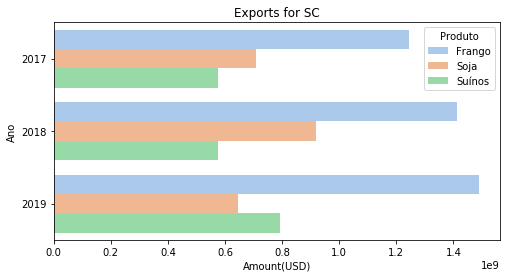

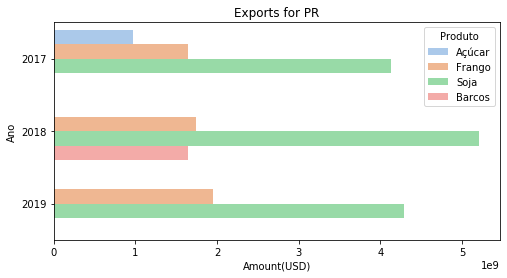

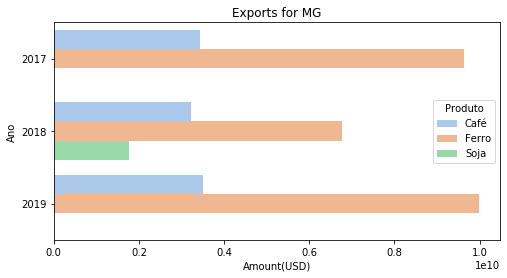

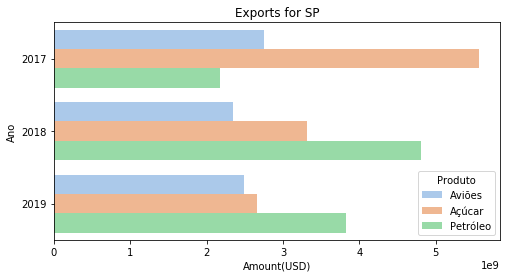

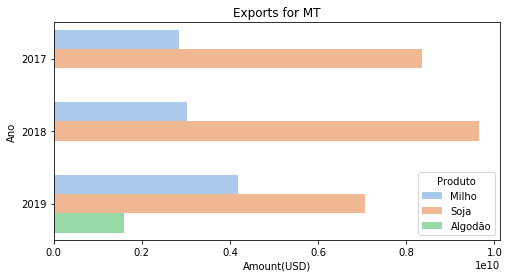

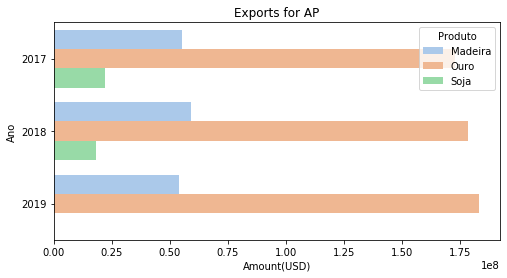

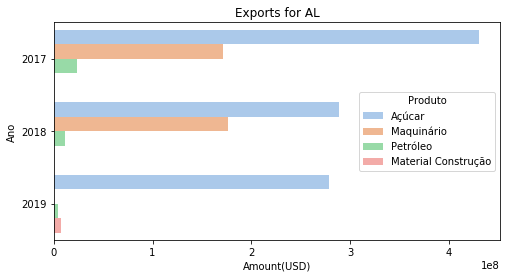

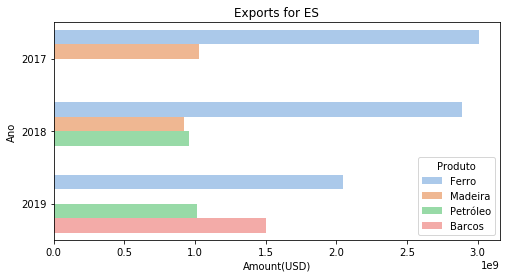

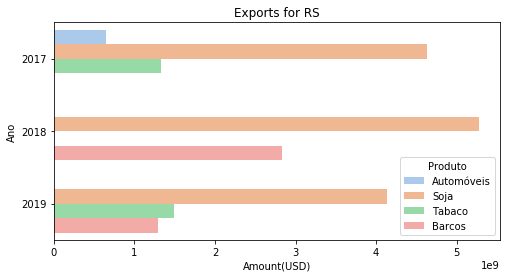

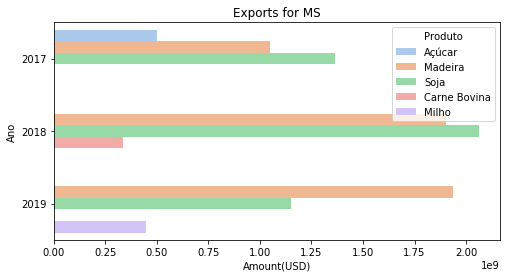

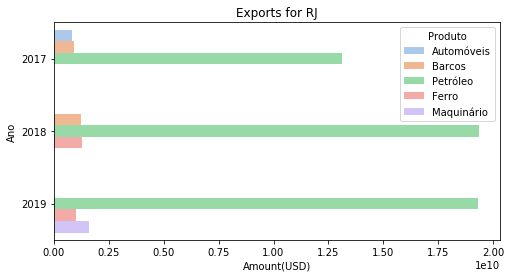

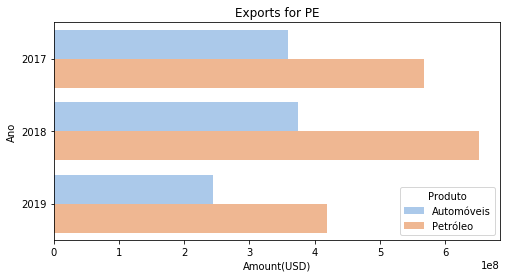

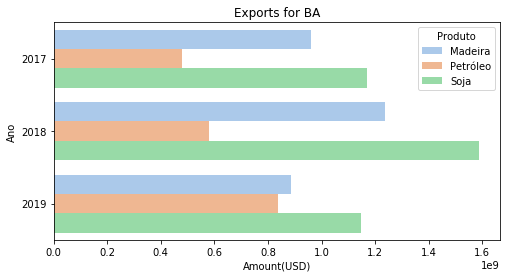

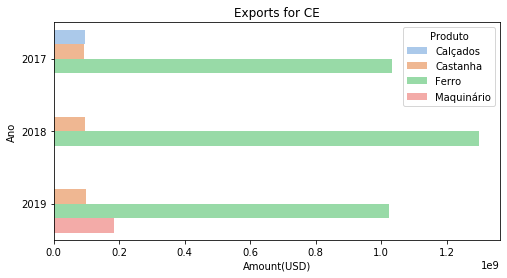

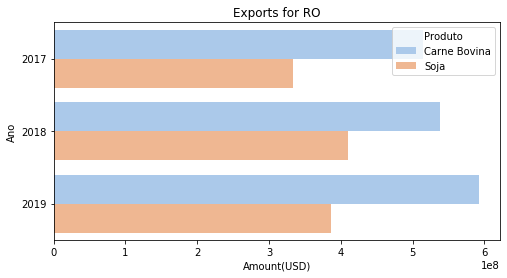

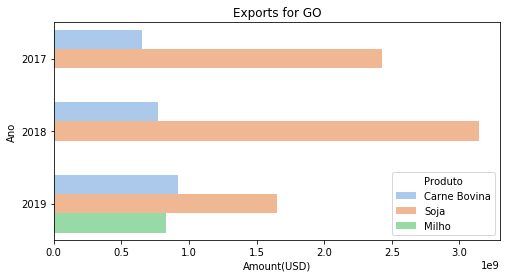

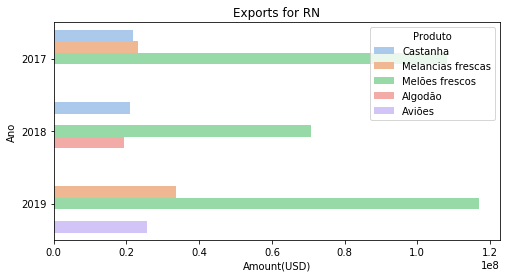

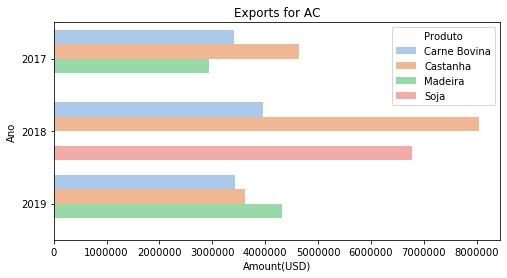

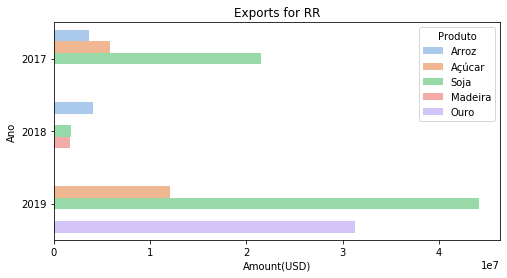

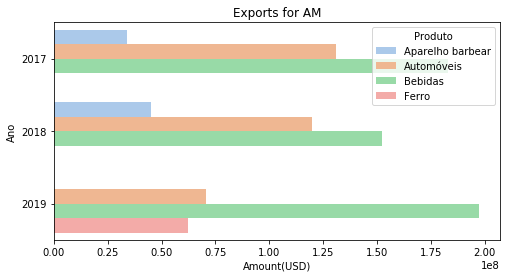

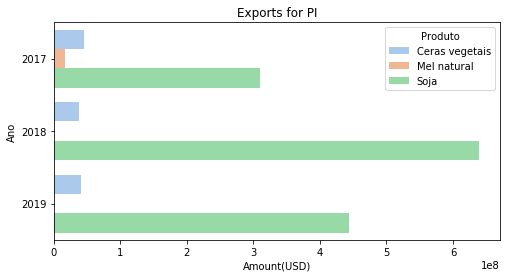

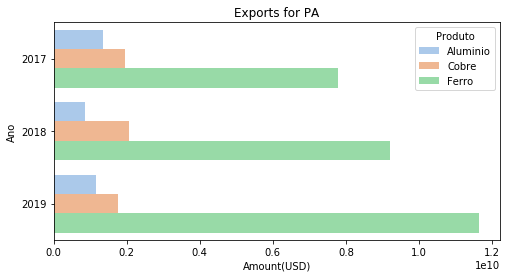

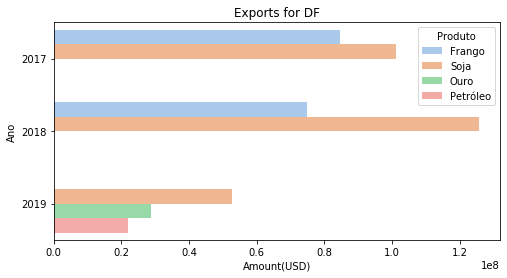

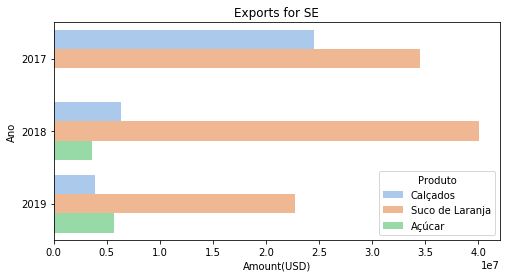

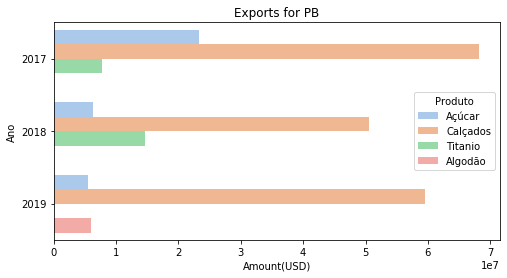

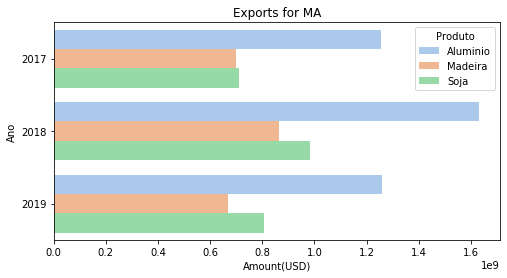

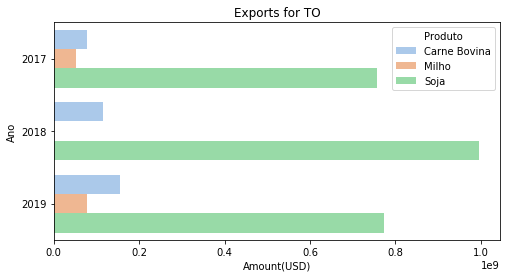

In [85]:
state_list = exp_df['Estado'].drop_duplicates().tolist()

for i,state in enumerate(state_list):
    plt.figure(i,figsize=(8,4))
    
    ax = sns.barplot(
        x="Amount(USD)", 
        y="Ano",
        data=exp_grouped[exp_grouped['Estado']==state], 
        hue="Produto", 
        orient="h", 
        palette='pastel').set_title('Exports for '+state)




We have a rate of around 1:1 of product to state. This leaves us some 

In [86]:
exp_grouped = exp_df[exp_df['Ano']==2019].groupby(['Ano','Mes','Estado','Produto'], as_index=False)['Amount(USD)'].sum()
exp_grouped = exp_grouped.sort_values(by='Amount(USD)',ascending=False)
exp_grouped = exp_grouped.groupby(['Ano','Mes','Estado']).head(3)
exp_grouped = exp_grouped.sort_values(by=['Estado','Mes','Ano'],ascending=False)
exp_grouped.head(10)

,Ano,Mes,Estado,Produto,Amount(USD)
237531,2019,12,TO,"Soja, mesmo triturada, exceto para semeadura",24404810
237509,2019,12,TO,"Carnes desossadas de bovino, congeladas",21599502
237515,2019,12,TO,"Milho em grão, exceto para semeadura",4946941
217277,2019,11,TO,"Soja, mesmo triturada, exceto para semeadura",39979339
217243,2019,11,TO,"Carnes desossadas de bovino, congeladas",25670606
217250,2019,11,TO,"Milho em grão, exceto para semeadura",5680944
197415,2019,10,TO,"Soja, mesmo triturada, exceto para semeadura",36715944
197392,2019,10,TO,"Carnes desossadas de bovino, congeladas",18106841
197397,2019,10,TO,"Milho em grão, exceto para semeadura",13944446
176775,2019,9,TO,"Soja, mesmo triturada, exceto para semeadura",76427859


In [ ]:
exp_grouped['Produto'].drop_duplicates().count()

In [ ]:
exp_grouped = exp_df[exp_df['Ano']==2019].groupby(['Ano','Estado'], as_index=False)['Amount(USD)'].sum()
exp_grouped.head(10)

In [ ]:
total_sum = exp_grouped['Amount(USD)'].sum()
print(total_sum)

In [ ]:
exp_grouped['percentage'] = exp_grouped.apply(lambda x: (x['Amount(USD)'] / total_sum) * 100, axis=1)
exp_grouped = exp_grouped.sort_values(by='percentage',ascending=False)
exp_grouped.head(10)

In [ ]:
plt.figure(figsize=(16, 10))
ax = sns.barplot(x="percentage", y="Estado",data=exp_grouped)
ax.set_title("Percentage of Exports for 2019")